<a href="https://colab.research.google.com/github/alexanderknysh/adcpml/blob/main/adcpml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A machine learning algorithm for ADCP data processing

[**Alexander Knysh, GitHub**](https://github.com/alexanderknysh/adcpml)

The present algorithm aims to select several typical and extreme environmental data samples (up to about 20-30) from near-shore [acoustic doppler current profiler](https://en.wikipedia.org/wiki/Acoustic_Doppler_current_profiler) (ADCP) measurements for further marine engineering analysis. Performance of the metod as well as the hyperparameter tuning are demonstrated on the example of ADCP datasets obtained by the Wood Island research site, Maine, USA. Two ADCPs were used to monitor environmental conditions around a kelp farm installation and were placed *42 m* away from each other. The devices measured water depth, significant wave height, significant wave period, and current velocity profiles averaged over *15 min* intervals from May 16 to May 28, 2019. Additional details on the research can be found in [Section 3.2 of this paper](https://github.com/alexanderknysh/thinplaterbf/blob/main/Methodology%20for%20multidimensional%20approximation%20of%20current%20velocity%20fields%20around%20offshore%20aquaculture%20installations.pdf).

## Libraries and functions
Before we start processing the ADCP datasets, let's first list libraries needed for the analysis, such as [`numpy`](https://numpy.org/), [`pandas`](https://pandas.pydata.org/), [`sklearn`](https://scikit-learn.org/stable/), etc.

In [61]:
# required libraries
import pandas              as pd
import numpy               as np
import math                as m
import matplotlib.pyplot   as plt
import plotly.express      as px
from collections           import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster       import KMeans
from sklearn.neighbors     import LocalOutlierFactor
from sklearn               import metrics

Define a function that will format velocity profiles to the total fluid energy in the upper ocean layers.

In [98]:
# function that formats velocity profiles
def format_profile(data, top): 
  output = np.empty((0,top))
  for i in range(data.shape[0]):
    row = data[i]
    row = row[np.logical_not(np.isnan(row))]
    row = row[-top:]
    row = np.dot(row, row)
    output = np.append(output, row)
  return output

Another function to show a set of line or scatter plots.

In [128]:
# functions that shows set of plots
def show_plot_set(abs, ord, types, colors, legends, ordlims, \
                  plots=5, sizes=(20, 15), dots=72, legloc='upper right', cmaps='plasma', alphas=1):
  fig, axs = plt.subplots(plots, figsize=sizes, dpi=dots)
  if types=='line':
    for i in range(plots):
      axs[i].plot(abs, ord.iloc[:,i], c=colors[i], label=legends[i])
      axs[i].set_ylim(ordlims[i])
      axs[i].legend(loc=legloc)
  if types=='scatter':
    for i in range(plots):
      axs[i].scatter(x=abs, y=ord.iloc[:,i], c=colors, cmap=cmaps, alpha=alphas)
      axs[i].set_ylabel(legends[i])
      axs[i].set_ylim(ordlims[i])
  plt.show()

And finally, a function to show a single plot.

In [129]:
# functions that shows single plot
def show_plot(abs, ord, types, abslabel, ordlabel, abslim, ordlim, \
              sizes=(10, 5), dots=100, marker='-o'):
  plt.figure(figsize=sizes, dpi=dots)
  if types=='line':
    plt.plot(abs, ord, marker, zorder=3)
  if types=='bar':
    plt.bar(abs, ord, zorder=3)
  plt.xlabel(abslabel)
  plt.ylabel(ordlabel)
  plt.xlim(abslim)
  plt.ylim(ordlim)
  plt.grid(zorder=0)
  plt.show()

## Data formatting

Next, upload the datasets from the [github repository](https://github.com/alexanderknysh/adcpml).

In [101]:
# read datasets common for both adcps:  wave properties and water depth
adcpdata = pd.read_excel('https://github.com/alexanderknysh/adcpml/blob/main/data_adcp_cm.xlsx?raw=true')
adcpdata.rename(columns={'Date': 'DateTime'}, inplace=True)

# read velocity dataset: west and east adpc profiles
west_vx  = pd.read_excel('https://github.com/alexanderknysh/adcpml/blob/main/west_adcp_vx.xlsx?raw=true')
west_vy  = pd.read_excel('https://github.com/alexanderknysh/adcpml/blob/main/west_adcp_vy.xlsx?raw=true')
east_vx  = pd.read_excel('https://github.com/alexanderknysh/adcpml/blob/main/east_adcp_vx.xlsx?raw=true')
east_vy  = pd.read_excel('https://github.com/alexanderknysh/adcpml/blob/main/east_adcp_vy.xlsx?raw=true')

# other important data
samples = range(0, adcpdata.shape[0])  # range of all data samples
alpha   = 13*m.pi/180                  # major axis of tidal ellipse (13 degrees)
cells   = 9                            # number of the upper measurement cells

In ocean engineering, tidal-driven current velocities are usually represented in terms of **projections on major and minor axes of a tidal ellipse**. In this study, we are mostly interested in the major projections since they have the highest absolute values of current velocities. Both west and east major velocity profiles are converted to the energy values that represent total kinetic energy in the upper water layers (*4 m* deep). This also **reduces number of features** we have to deal with in the future.

In [102]:
# project the velocity profiles on the major axis of the tidal ellipse
west_major = west_vx * m.cos(alpha) - west_vy * m.sin(alpha)
east_major = east_vx * m.cos(alpha) - east_vy * m.sin(alpha)
west_major = west_major.to_numpy()
east_major = east_major.to_numpy()
adcpdata['WestEnergy'] = format_profile(west_major, cells)
adcpdata['EastEnergy'] = format_profile(east_major, cells)

# format and rename date column
adcpdata['DateTime'] = adcpdata['DateTime'].astype('datetime64[s]')

# save dataset with no date column
adcpdata_nodate = adcpdata.drop('DateTime', axis='columns')

# display the full resulting dataset
pd.options.display.show_dimensions = False
display(adcpdata)

,DateTime,WaterDepth,WaveHeight,WavePeriod,WestEnergy,EastEnergy
0,2019-05-16 14:15:00,9.475,0.235,11.075,0.174540,0.136834
1,2019-05-16 14:30:00,9.395,0.250,12.150,0.271423,0.177364
2,2019-05-16 14:45:00,9.289,0.240,11.370,0.249177,0.214879
3,2019-05-16 15:00:00,9.160,0.235,11.555,0.355531,0.250243
4,2019-05-16 15:15:00,9.007,0.210,11.640,0.471080,0.328769
...,...,...,...,...,...,...
1157,2019-05-28 15:29:54,7.275,0.275,8.780,0.025099,0.019459
1158,2019-05-28 15:44:54,7.176,0.260,8.640,0.063899,0.029413
1159,2019-05-28 15:59:54,7.083,0.260,8.660,0.072142,0.073600
1160,2019-05-28 16:14:54,7.040,0.280,8.360,0.097749,0.094061


Note that terms like significant wave height/period and representative values for current energy at east/west ADCPs are shortened to *WaveHeight*, *WavePeriod*,	*WestEnergy*, *EastEnergy*, respectively. Let's now visualize the final dataset over sample numbers using [`matplotlib`](https://matplotlib.org/).

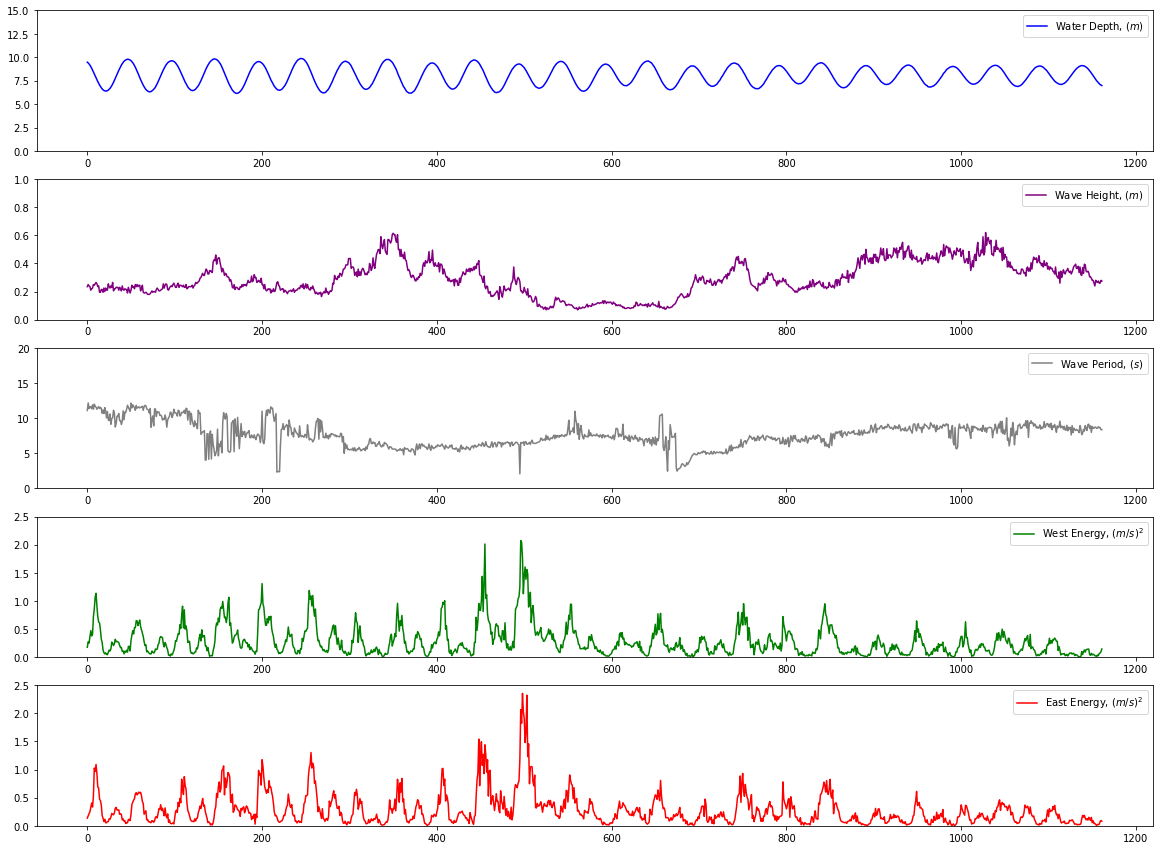

In [130]:
# visualize the adcp data
colors  = ['blue', 'purple', 'gray', 'green', 'red']
legends = ['Water Depth, $(m)$', 'Wave Height, $(m)$', 'Wave Period, $(s)$', 'West Energy, $(m/s)^2$', 'East Energy, $(m/s)^2$']
ylims   = [[0, 15], [0, 1], [0, 20], [0, 2.5], [0, 2.5]]
show_plot_set(samples, adcpdata_nodate, 'line', colors, legends, ylims)

## Data scaling

Even though we have processed the raw ADCP data, it must be still modified before using a clustering algorithm. The problem is that ranges of the feature values vary significantly, and this leads to machine learning algorythms to perform poorly. Thus, the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) from [`sklearn`](https://scikit-learn.org/stable/) is applied to standardize features by removing the mean and scaling to unit variance.

In [104]:
# apply standard scaler
scaler = StandardScaler()
scaler.fit(adcpdata_nodate)
adcpdata_scaled = scaler.fit_transform(adcpdata_nodate)
adcpdata_scaled = pd.DataFrame(adcpdata_scaled, columns=adcpdata_nodate.columns)

# display scaled data
display(adcpdata_scaled)

,WaterDepth,WaveHeight,WavePeriod,WestEnergy,EastEnergy
0,1.422928,-0.449727,1.936302,-0.387866,-0.515059
1,1.343870,-0.326437,2.536732,-0.033365,-0.373893
2,1.239117,-0.408630,2.101071,-0.114764,-0.243228
3,1.111635,-0.449727,2.204401,0.274392,-0.120053
4,0.960436,-0.655209,2.251877,0.697193,0.153459
...,...,...,...,...,...
1157,-0.751181,-0.120955,0.654453,-0.934683,-0.923883
1158,-0.849016,-0.244245,0.576258,-0.792711,-0.889214
1159,-0.940921,-0.244245,0.587428,-0.762548,-0.735306
1160,-0.983415,-0.079859,0.419867,-0.668851,-0.664039


Take a look at the scaled data.

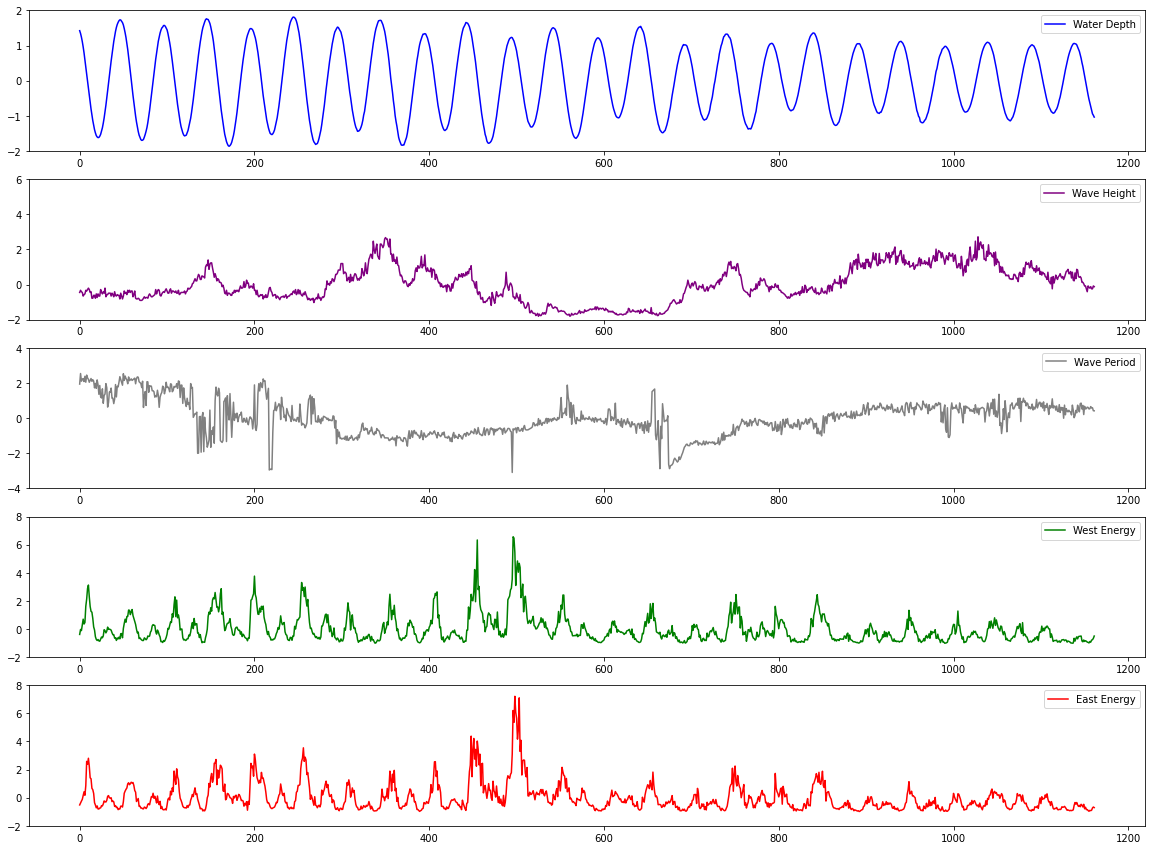

In [105]:
# visualize the scaled adcp data
colors  = ['blue', 'purple', 'gray', 'green', 'red']
legends = ['Water Depth', 'Wave Height', 'Wave Period', 'West Energy', 'East Energy']
ylims   = [[-2, 2], [-2, 6], [-4, 4], [-2, 8], [-2, 8]]
show_plot_set(samples, adcpdata_scaled, 'line', colors, legends, ylims)

While there is not that much correlation between wated depth, wave height and wave period, the connection between water depth and current energy is very clear. Let's zoom in to see high and low tides.

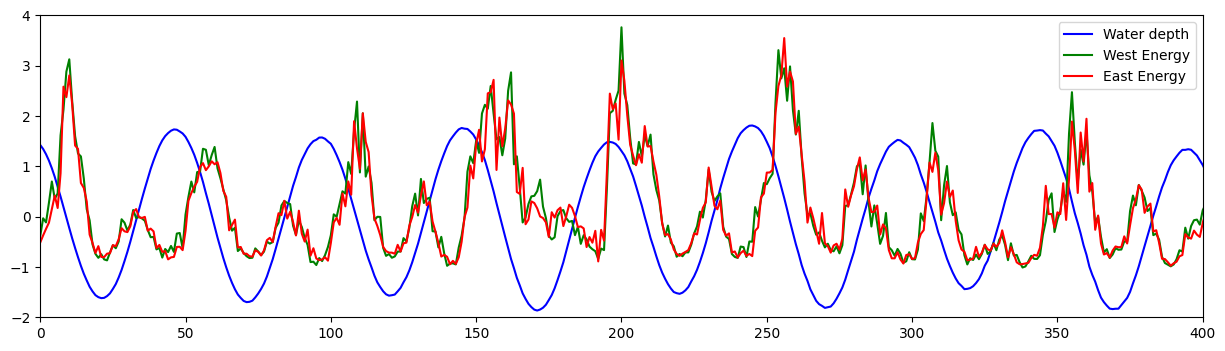

In [106]:
# plot water depth, west and east energies
fig, axs = plt.subplots(figsize=(15, 4), dpi=100)
axs.plot(samples, adcpdata_scaled.iloc[:,0], c='blue', label='Water depth')
axs.plot(samples, adcpdata_scaled.iloc[:,3], c='green', label='West Energy')
axs.plot(samples, adcpdata_scaled.iloc[:,4], c='red', label='East Energy')
axs.set_xlim([0, 400])
axs.set_ylim([-2, 4])
axs.legend(loc='upper right')
plt.show()

## Principle component analysis

As we can see from the west and east energy figures, both values are not identical but very close to each other. There is an intuition that we could further reduce number of features without loss of generality. In order to do so, machine learning scientist usually utilize the so-called [principle component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) and measure amount of varience lost from particular feature number reductions. In this study, we check total explained varience and apply the default [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA) algorithm available in [`sklearn`](https://scikit-learn.org/stable/).

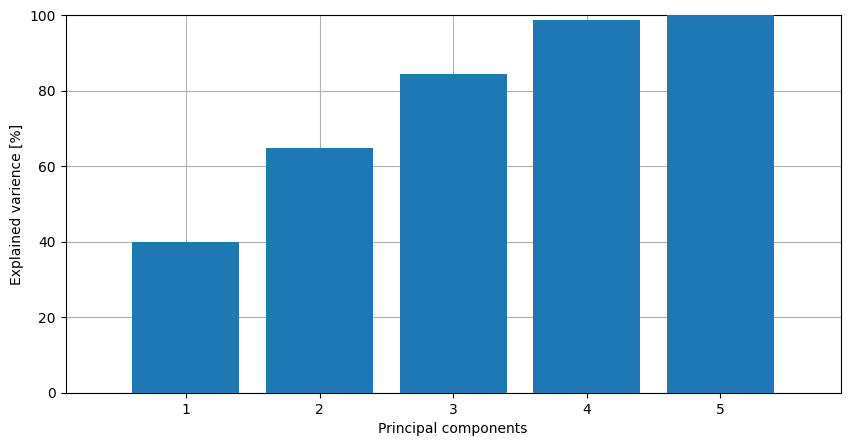

In [117]:
# principle component analysis
variance = []
dimensions = range(1, len(adcpdata_scaled.columns)+1)

# test different number of principal components
for i in dimensions:
  pca = PCA(n_components=i)
  adcpdata_pca = pca.fit_transform(adcpdata_scaled)
  variance.append(sum(pca.explained_variance_ratio_))

# total variance in percentages
variance = [100 * value for value in variance]

# variance bar plot
show_plot(dimensions, variance, 'bar', 'Principal components', 'Explained varience [%]', [0.1, 5.9], [0, 100])

It turns out that selecting 4 *principal components* (PC) reduces explained varience by less than *1%* since west and east energy datasets are similar. On the other hand, **selecting 3 principal components** provides a great trade-off between explained varience of about *85%* and ability to visualize future data clusters, so we will use it this option for our future analysis.

In [118]:
# select 3 principal components
pca = PCA(n_components=3)
adcpdata_pca = pca.fit_transform(adcpdata_scaled)
adcpdata_pca = pd.DataFrame(adcpdata_pca, columns = ['PC1','PC2','PC3'])

# display adcp data in PCs
display(adcpdata_pca)

,PC1,PC2,PC3
0,-0.542901,0.170293,-1.957296
1,-0.251878,0.075295,-2.576086
2,-0.188105,0.063022,-2.123341
3,0.165864,-0.039788,-2.223830
4,0.684078,-0.235824,-2.242043
...,...,...,...
1157,-1.300526,-0.932942,-0.389172
1158,-1.152360,-1.046499,-0.283786
1159,-1.028734,-1.102536,-0.288122
1160,-0.946982,-0.972762,-0.161716


## Clustering

The [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) algorithm is applied to identify the typical data samples in the ADCP measurements, however an optimal number of clusters must be chosen in advance. Relatively small size of the dataset (1162 samples) allows us to test numerous cluster numbers. At the same time, more than **30 clusters** is meaningless in the application we consider. As we identified the cluster number limit, we can proceed with [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering)) and [Elbow](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) methods to find the optimal number of clusters.

In [119]:
# k-means clustering, identify the best k
clusters = range(2,31)
kmeans = []
labels = []
inertia = []
silhouette = []
cluster_delta = []

# silhouette and elbow methods
for k in clusters:
  kmeans.append(KMeans(n_clusters=k).fit(adcpdata_pca))
  labels.append(kmeans[k-2].fit_predict(adcpdata_pca))
  inertia.append(kmeans[k-2].inertia_)
  silhouette.append(metrics.silhouette_score(adcpdata_pca, kmeans[k-2].labels_))

Plot silhouette score against number of clusters.

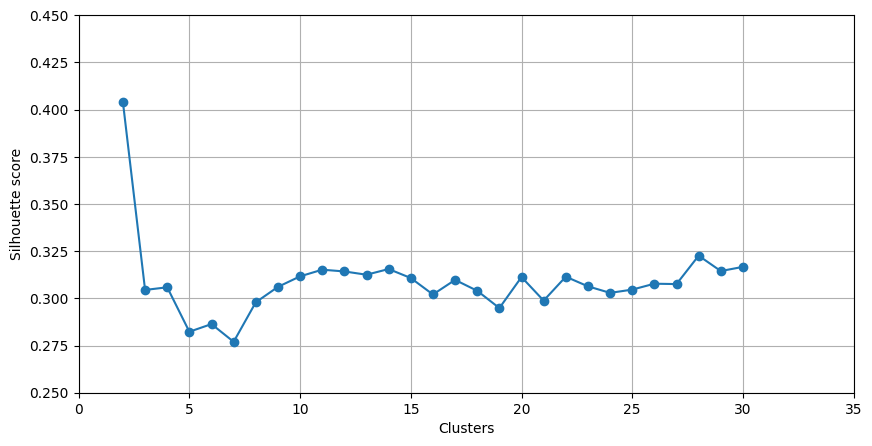

In [121]:
# plot silhouette score
show_plot(clusters, silhouette, 'line', 'Clusters', 'Silhouette score', [0, 35], [0.25, 0.45])

Plot inertia against number of clusters.

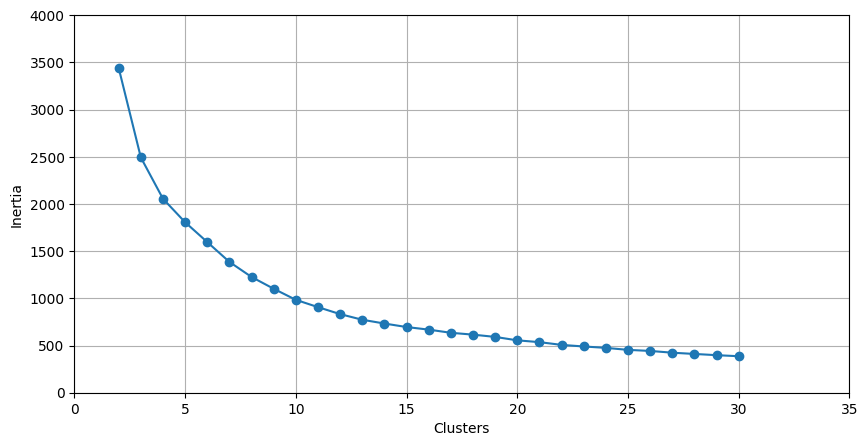

In [122]:
# plot inertia
show_plot(clusters, inertia, 'line', 'Clusters', 'Inertia', [0, 35], [0, 4000])

Unfortunately, we don't see any clear *elbow* in this case, however we can plot the change of inertia from cluster to cluster.

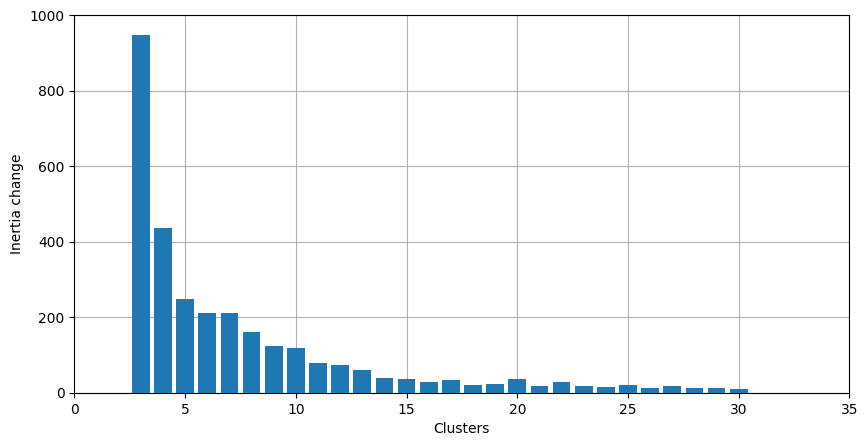

In [123]:
# plot inertia change from cluster to cluster
show_plot(np.delete(clusters, 0), -np.diff(inertia), 'bar', 'Clusters', 'Inertia change', [0, 35], [0, 1000])

Split into 10 clusters and display the final dataset.

In [131]:
# selected 10 clusters and create corresponding pandas dataframe
clusters_pca = 10
colormap = labels[clusters_pca-2]+1
adcpdata_pca['Cluster'] = colormap

# display data in terms of principal components
display(adcpdata_pca)

,PC1,PC2,PC3,Cluster
0,-0.542901,0.170293,-1.957296,5
1,-0.251878,0.075295,-2.576086,5
2,-0.188105,0.063022,-2.123341,5
3,0.165864,-0.039788,-2.223830,7
4,0.684078,-0.235824,-2.242043,7
...,...,...,...,...
1157,-1.300526,-0.932942,-0.389172,10
1158,-1.152360,-1.046499,-0.283786,10
1159,-1.028734,-1.102536,-0.288122,10
1160,-0.946982,-0.972762,-0.161716,10


Plot interactive 3D plot with the clusters to double-check the result ([Open in Colab](https://colab.research.google.com/github/alexanderknysh/adcpml/blob/main/adcpml.ipynb)).

In [ ]:
#plot clusters in 3D
fig = px.scatter_3d(adcpdata_pca, x='PC1', y='PC2', z='PC3', color='Cluster', width=1000, height=700)
fig.show()

Plot water depth, west energy and east energy for 10 clusters.

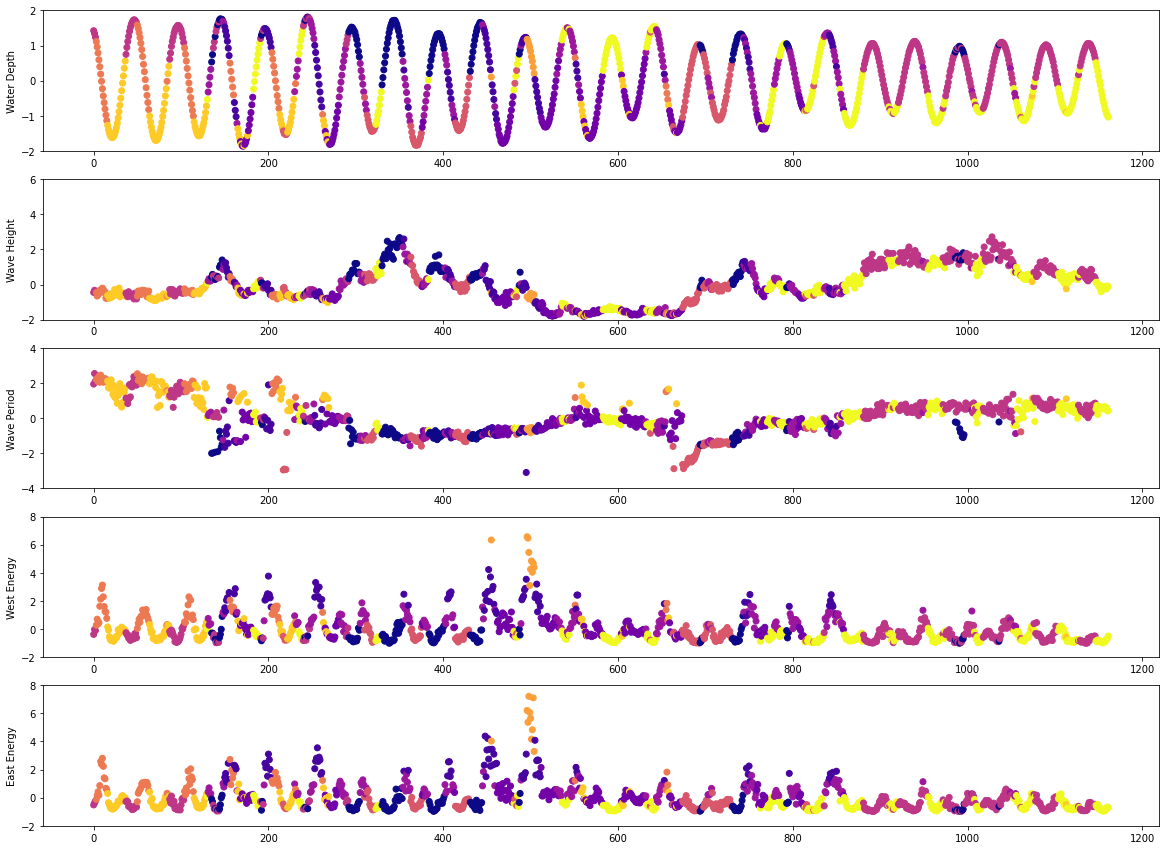

In [132]:
# visualize clusters
colors  = colormap
legends = ['Water Depth', 'Wave Height', 'Wave Period', 'West Energy', 'East Energy']
ylims   = [[-2, 2], [-2, 6], [-4, 4], [-2, 8], [-2, 8]]
show_plot_set(samples, adcpdata_scaled, 'scatter', colors, legends, ylims)

Obtain new colormaps for each cluster.

In [133]:
# create new binary colormaps for every cluster
clustermaps = []

for i in range(clusters_pca):
  tempmap = list(colormap)
  for j in samples:
    if tempmap[j]!=i+1:
      tempmap[j]=0
  clustermaps.append(tempmap)

Highlight one of the 10 clusters.

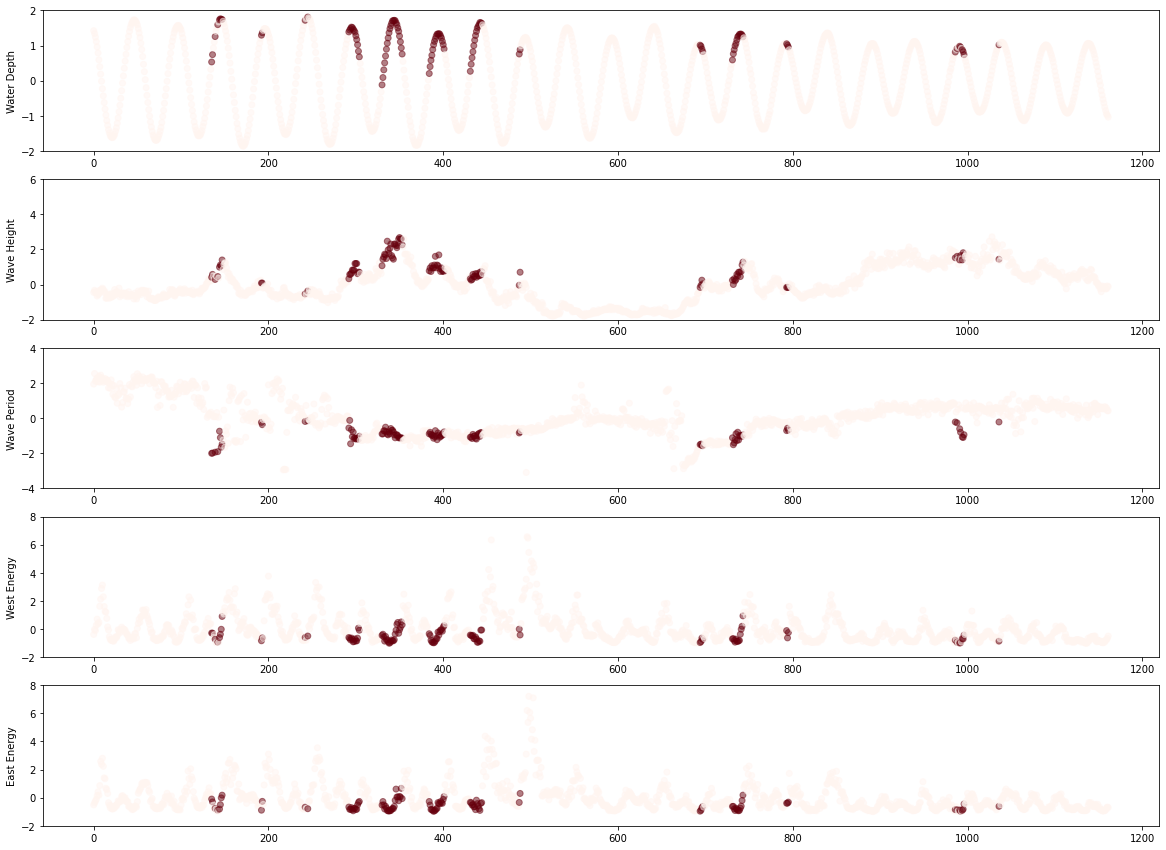

In [134]:
# visualize the adcp data
clplot  = 1
colors  = clustermaps[clplot-1]
legends = ['Water Depth', 'Wave Height', 'Wave Period', 'West Energy', 'East Energy']
ylims   = [[-2, 2], [-2, 6], [-4, 4], [-2, 8], [-2, 8]]
show_plot_set(samples, adcpdata_scaled, 'scatter', colors, legends, ylims, cmaps='Reds', alphas=0.5)

As the clusters are identified, the most typical sample in each cluster must now be selected. In this study we propose to list samples with the lowest total **Euclidean distance** to the rest of the samples in its cluster.

In [135]:
# search for the indices of the typical samples
indices = []
for j in range(clusters_pca):
  dist = kmeans[clusters_pca-2].transform((adcpdata_pca.iloc[: , :-1]))[:, j]
  indices.append(min(range(len(dist)), key=dist.__getitem__))

# display the final result
typical = adcpdata.iloc[indices]
display(typical)

,DateTime,WaterDepth,WaveHeight,WavePeriod,WestEnergy,EastEnergy
439,2019-05-21 03:59:57,9.549,0.365,5.820,0.022162,0.163124
202,2019-05-18 16:44:58,9.148,0.220,6.350,0.885962,0.861600
265,2019-05-19 08:29:58,6.573,0.190,7.000,0.298709,0.336520
546,2019-05-22 06:44:57,9.387,0.130,7.365,0.312589,0.471319
926,2019-05-26 05:44:55,8.011,0.510,8.775,0.225888,0.147954
709,2019-05-23 23:29:56,7.286,0.280,5.080,0.123085,0.099844
207,2019-05-18 17:59:58,8.256,0.220,11.225,0.608330,0.592228
455,2019-05-21 07:59:57,8.142,0.235,6.075,2.010858,1.440629
215,2019-05-18 19:59:58,6.787,0.205,10.060,0.172660,0.179855
876,2019-05-25 17:14:55,7.667,0.335,7.925,0.138892,0.185848


## Anomaly detection

In order to select samples significantly different from the others, the [local outlier algorithm](https://en.wikipedia.org/wiki/Local_outlier_factor) (LOF) was utilized. The implementation of the [`LocalOutlierFactor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html?highlight=localoutlierfactor#sklearn.neighbors.LocalOutlierFactor) from [`sklearn`](https://scikit-learn.org/stable/) can be seen below. Similarly to siluette score and inertia in the clustering problem, the new hyperparameter (number of neighbor samples) will be chosen based on total **negative outlier factor** (NOF) and resulting **number of outliers**. NOF is a measure of how close the sample to be an inlier or an outlier. The closer sample NOF to -1, the more likely for it to be an inlier. NOF significantly lower than -1 are likely to be the outliers. Finally, the higher the total NOF, the better the outlier detection.

In [83]:
# calculate total NOF and outliers for different number of neighbours
neighbors = range(1,181)
factors = []
outliers = []
total_factor = []
total_outliers = []

for i in neighbors:
  lof = LocalOutlierFactor(n_neighbors=i)
  outliers.append(lof.fit_predict(adcpdata_scaled))
  factors.append(lof.negative_outlier_factor_)
  total_outliers.append(list(Counter(outliers[i-1]).values())[1])
  total_factor.append(sum(factors[i-1]))

Plot number of neighbors against total NOF.

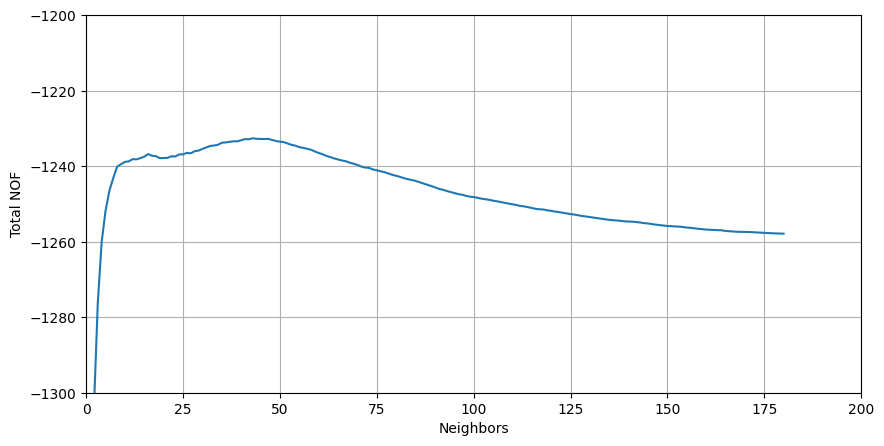

In [137]:
# plot total NOF
show_plot(neighbors, total_factor, 'line', 'Neighbors', 'Total NOF', [0, 200], [-1300, -1200], marker='-')

Find number of neighbours for maximum NOF.

In [138]:
# print number of neighbours for maximum NOF value
neighbors_lof = max(range(len(total_factor)), key=total_factor.__getitem__)
print('Optimal number of neighbors: ', neighbors_lof)

Optimal number of neighbors:  42


 Double-check the corresponding number of outliers.

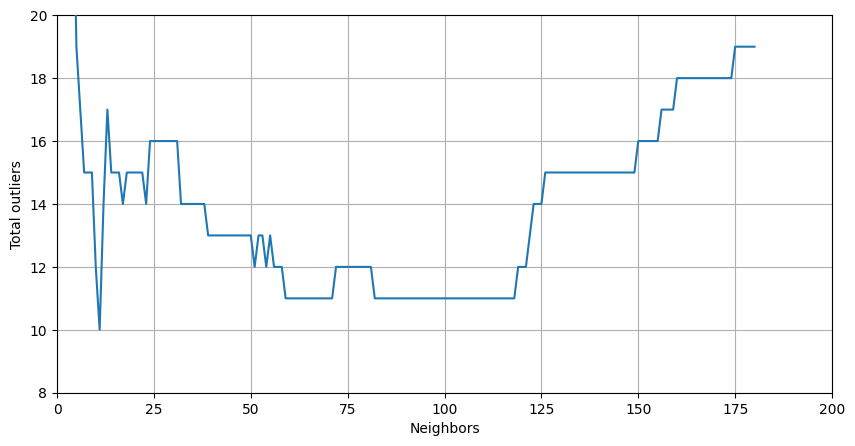

In [140]:
# plot total outliers
show_plot(neighbors, total_outliers, 'line', 'Neighbors', 'Total outliers', [0, 200], [8, 20], marker='-')

Print number of outliers.

In [141]:
# print number of ouliers
print('Corresponding number of outliers: ', total_outliers[neighbors_lof-1])

Corresponding number of outliers:  13


Visualize NOFs of the samples.

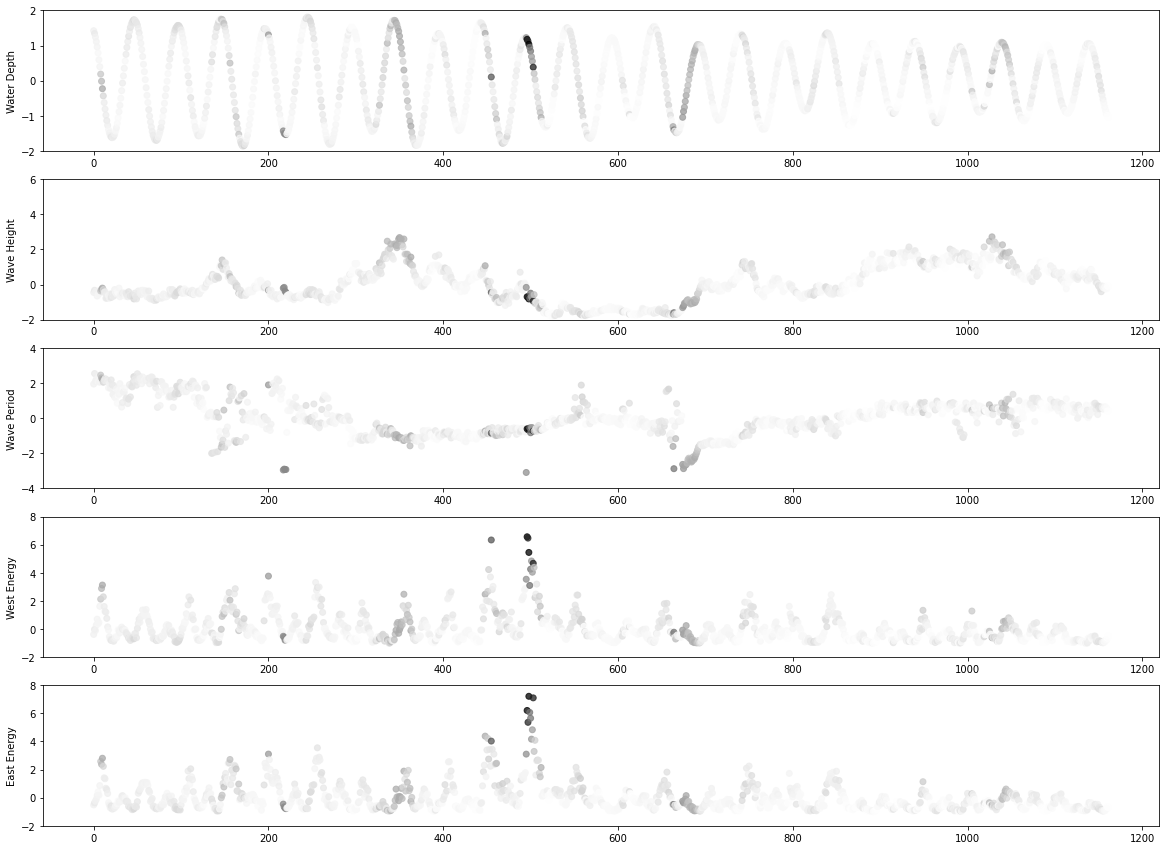

In [142]:
# visualize NOFs
colors  = factors[neighbors_lof-1]
legends = ['Water Depth', 'Wave Height', 'Wave Period', 'West Energy', 'East Energy']
ylims   = [[-2, 2], [-2, 6], [-4, 4], [-2, 8], [-2, 8]]
show_plot_set(samples, adcpdata_scaled, 'scatter', colors, legends, ylims, cmaps='gray', alphas=0.75)

Plot the outliers.

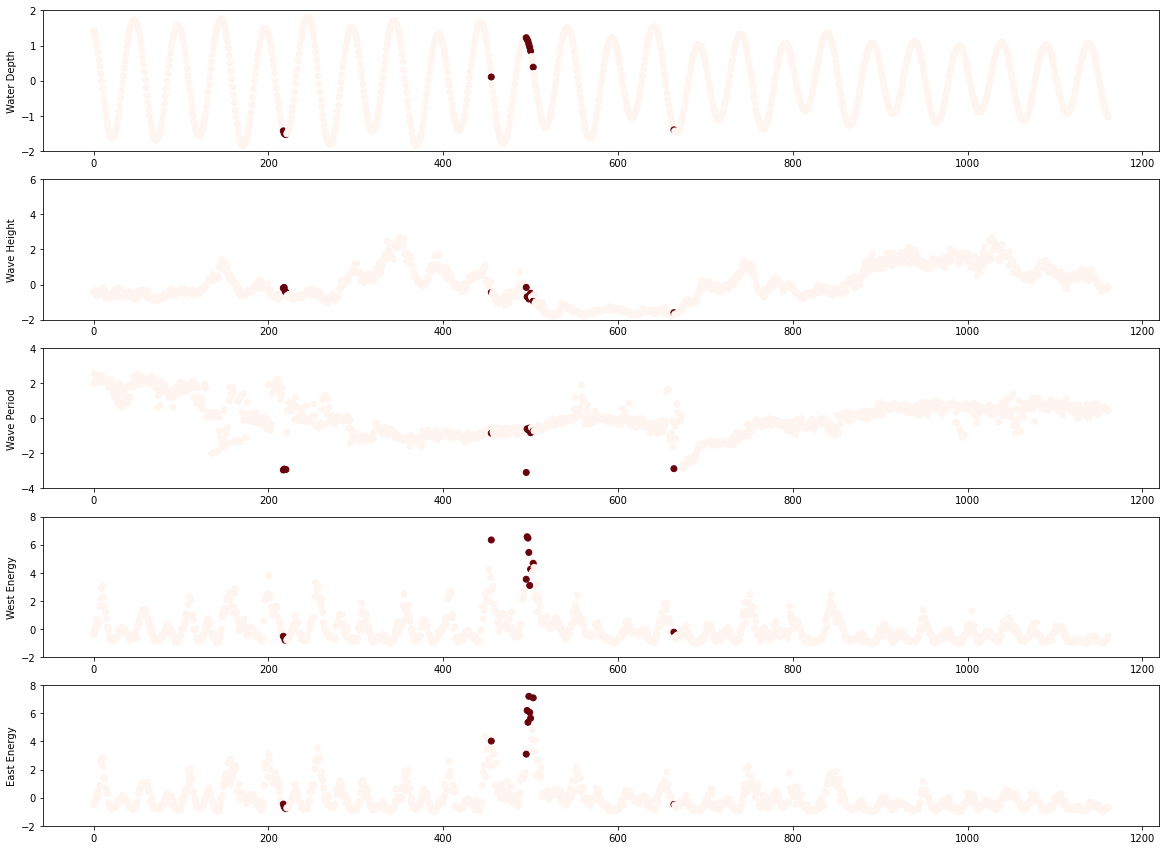

In [143]:
# plot the outliers
colors  = -outliers[neighbors_lof-1]
legends = ['Water Depth', 'Wave Height', 'Wave Period', 'West Energy', 'East Energy']
ylims   = [[-2, 2], [-2, 6], [-4, 4], [-2, 8], [-2, 8]]
show_plot_set(samples, adcpdata_scaled, 'scatter', colors, legends, ylims, cmaps='Reds')

Display the final table with the outlier samples.

In [144]:
# final table
indeces_lof = np.where(outliers[neighbors_lof-1] == -1)
extreme = adcpdata.iloc[indeces_lof]
display(extreme)

,DateTime,WaterDepth,WaveHeight,WavePeriod,WestEnergy,EastEnergy
217,2019-05-18 20:29:58,6.590,0.265,2.3200,0.138710,0.153322
218,2019-05-18 20:44:58,6.519,0.270,2.4125,0.119482,0.097392
219,2019-05-18 20:59:58,6.496,0.245,2.3800,0.062736,0.071739
220,2019-05-18 21:14:58,6.483,0.235,2.3700,0.077718,0.061038
455,2019-05-21 07:59:57,8.142,0.235,6.0750,2.010858,1.440629
495,2019-05-21 17:59:57,9.273,0.270,2.0700,1.247442,1.174273
496,2019-05-21 18:14:57,9.225,0.205,6.5150,2.072987,2.065725
497,2019-05-21 18:29:57,9.174,0.205,6.4150,2.046979,1.823695
498,2019-05-21 18:44:57,9.084,0.190,6.5150,1.768551,2.355101
499,2019-05-21 18:59:57,8.996,0.195,6.6050,1.126666,2.026475


Finally, both `typical` and `extreme` datasets are selected!